In [1]:
import tensorflow as tf
import cv2
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [2]:
# part1 : style 부분

In [3]:
style_path = tf.keras.utils.get_file("style.jpg", "http://bit.ly/2mGfZIq")
style_image = plt.imread(style_path)

337723/337723 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


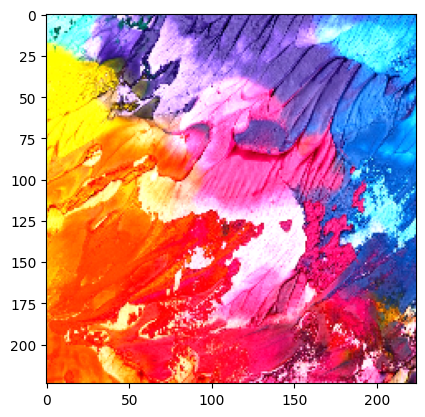

In [4]:
style_image = cv2.resize(style_image, (224, 224))
style_image = style_image/ 225.
plt.imshow(style_image)

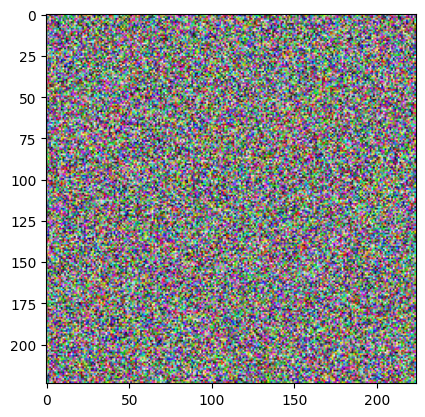

In [5]:
target_image = tf.random.uniform(style_image.shape)
plt.imshow(target_image)

In [8]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

In [9]:
vgg = VGG19(include_top=False, weights="imagenet")
vgg

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


<Functional name=vgg19, built=True>

In [11]:
for layer in vgg.layers:
    print(layer.name)

input_layer
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [12]:
# 필요한 레이어들에 대한 리스트업
style_layers = ["block1_conv1",
                "block2_conv1",
                "block3_conv1",
                "block4_conv1",
                "block5_conv1"]
vgg.trainable = False

In [14]:
# style 에 대한 vgg를 통한 여러 블럭에서 나오는 FM을 담자
outputs = [vgg.get_layer(name).output for name in style_layers]
model = tf.keras.Model([vgg.input], outputs)

In [23]:
# gram-matrix 에 대한 정의 -> loss_style 에 대한 정의
def gram_matrix( input_tensor ):
    # (224, 224, 64) -> WH 중심으로 1D 벡터화 (64, 224*224)
    # X * X^T = (64, 224*224) X (224*224, 64) = (64,64)
    ch = int(input_tensor.shape[-1])
    x = tf.reshape(input_tensor, [-1, ch])
    n = tf.shape(x)[0]
    gram = tf.matmul(x,x,transpose_a=True)
    return gram/ tf.cast( n, tf.float32)

In [24]:
# vgg에 입력으로 여러 이미지를 밀어 넣어서 학습하는 것이 아니라
# 기존과 다른 방식으로 1장을 넣어서 FM을 추출
# 입력에 대한 대상을 명시적으로 1장이라고 해줘야 함. VGG네트워크에 입력으로 줄 수 있음
# (224,224,3) -> (1, 224,224,3) vgg 네트워크에 입력으로 줄 수 있음

style_batch = style_image.astype("float32")
style_batch = tf.expand_dims(style_batch, axis = 0)
print(style_batch.shape)

(1, 224, 224, 3)


In [25]:
# 입력 style 에 대한 FM을 추출하려 함
# style_out 은 Style_image 가 vgg를 통과해서 나온
# 각 블럭별의 FM들을 모아둔 것! (3차원의 FM들의 리스트)
# 주의!) loss 의 계산의 대상은 FM이 아니라 FM을 기본으로 하는 gram-matrix 가 대상임
style_out = model(preprocess_input(style_batch * 255.0)) #정규화 -> 늘리고 -> 정규화


In [26]:
# 비교를 하기 위한 FM -> Gram-matrix 으로 변환
style_outputs = [gram_matrix(out) for out in style_out]


In [27]:
# outputs 을 생성하는 함수
# 입력 : 이미지 1장
# 하는 일 : vgg 네트워크에 통과시켜서 각 블럭별로 FM을 추출, FM을 GM으로 변경한 것들을 출력
# 출력 : 각 특징별 GM들
def get_outputs(image):
    image_batch = tf.expand_dims(image, axis = 0)
    output = model(preprocess_input(image_batch * 255.0))
    outputs = [gram_matrix(out) for out in output]
    return outputs


In [ ]:
# loss 에 대한 계산을 해야함
# -> 양쪽에서의 각 블럭별로 나온 gram-matrix 들을 대상으로,,
# 입력으로 아래 그림의 야쪽 파란색블럭이 입력임
# 1개 파란색 블럭 안에는 각 conv 블럭에서 나온 G-M


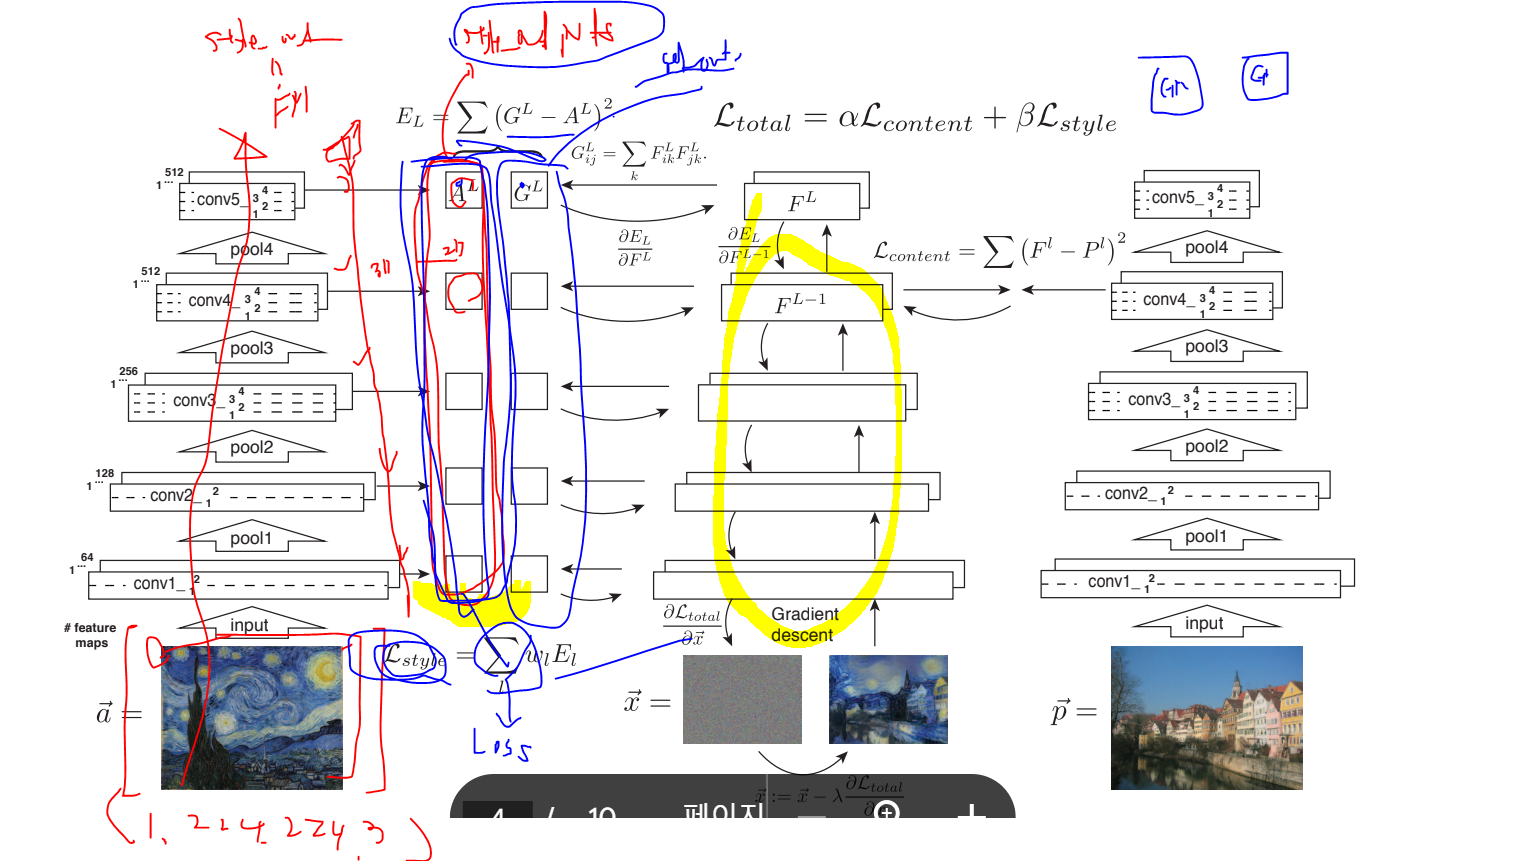

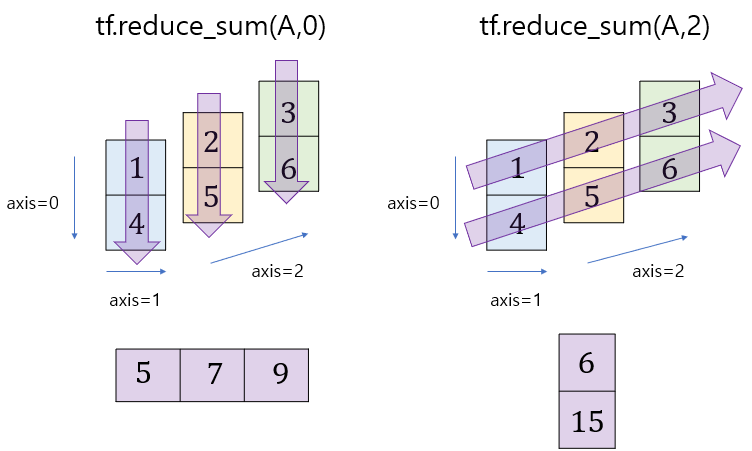

In [28]:
def get_loss(outputs, style_outputs):
    return tf.reduce_sum([tf.reduce_mean((o-s)**2) for o,s in zip(outputs, style_outputs)])

In [29]:
# len(style_outputs)

5

In [30]:
# style_outputs[0].shape

TensorShape([64, 64])

In [32]:
# tf.reduce_mean((style_outputs[0] - style_outputs[0])**2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [33]:
# 참고적인 모듈 : 값을 일정한 범위 내에 있도록 하는 것
# -> 레이어 단에서 AF를 sigmoid: 0~1, AF tanh : -1 ~+1 etc
# -> 직접 값들을 0~1로 처리해주는 모듈.. 0~1 사이로 제한
# TF 확정성을 위해서 원하는 min, max 을 세팅을 하는 모듈 : clip_by_value

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
# ==> 여기서는 0~1사이로 이미지의 값을 정규화 처리용으로 변환!!!!

In [34]:
# 최적화 관련 opt
# -> adam을 사용( 논문은 다른 opt )
opt = tf.optimizers.Adam(learning_rate=0.2,
                         beta_1=0.99,
                         epsilon=1e-1)

In [ ]:
## 미분을 수행하는 과정에 대해서 직접 설계!
#   -> 최근의 모델들을 다룰 때 종종 나타나는 코드가 됨!
#   -> 기존의 TF / PyTorch 같은 이미 만들어진 것들을 활용함
#        파이썬에서 Decorator 문법을 사용함

# @tf.function()
# @torch.function(), torch.grad()

In [37]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape :
        outputs = get_outputs(image)
        loss = get_loss(outputs, style_outputs)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

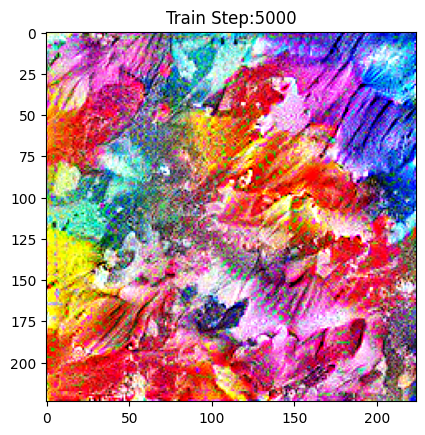

In [38]:
# Style에 대한 전이에 대한 부분의 반복
import IPython.display as display
import imageio
from PIL import Image


image = tf.Variable(target_image) # noise인 이미지를 Tensor 변수화

epochs = 50
step_per_epoch= 100

step = 0
for n in range(epochs):
    for m in range(step_per_epoch):
        step += 1
        train_step(image) # 학습을 시키는 과정
    # 옵션들
    if n % 5 ==0 or n == (epochs-1):
        # 실제 어떻게 학습을 했나, (바뀌었는지 실제로 확인)
        tf.keras.utils.save_img('style_epoch_{0}.png'.format(n),image.read_value().numpy())
    # 밑에 출력
    display.clear_output(wait=True) # 그냥 다 볼려면, False 하거나 주석
    plt.imshow( image.read_value() )
    plt.title("Train Step:{}".format(step))
    plt.show()


In [39]:
# part2: 적용할 대상을 명확하게 content img에 접목
# -> 앞의 코드를 조금 수정해서 content 에 적용
# content에 내용이 있으면서, style은 내가 지정한 이미지의 스타일을 따라하도록

In [40]:
# content_image를 하나 가지고 옴
content_path  = tf.keras.utils.get_file('content.jpg', 'http://bit.ly/2mAfUX1')
content_image = plt.imread(content_path)
content_image

754420/754420 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


array([[[  3,  49, 127],
        [  3,  49, 127],
        [  3,  49, 127],
        ...,
        [  6,  45, 112],
        [  6,  45, 112],
        [  6,  45, 112]],

       [[  3,  49, 127],
        [  3,  49, 127],
        [  3,  49, 127],
        ...,
        [  6,  45, 112],
        [  6,  45, 112],
        [  6,  45, 112]],

       [[  4,  50, 128],
        [  4,  50, 128],
        [  4,  50, 128],
        ...,
        [  6,  45, 112],
        [  6,  45, 112],
        [  6,  45, 112]],

       ...,

       [[139, 235, 234],
        [164, 255, 255],
        [154, 241, 255],
        ...,
        [ 48, 138, 162],
        [ 49, 144, 176],
        [ 37, 136, 175]],

       [[162, 238, 236],
        [179, 250, 254],
        [165, 229, 241],
        ...,
        [ 46, 139, 173],
        [ 28, 125, 168],
        [  5, 107, 155]],

       [[124, 195, 189],
        [128, 192, 191],
        [106, 161, 164],
        ...,
        [ 56, 151, 195],
        [ 37, 137, 189],
        [ 18, 123, 180]]

In [41]:
content_image.shape
# content 이미지가 해상도가 거의 FHD
# --> 적당하게 사이즈를 조절

(1460, 2200, 3)

In [42]:
content_image.shape[:-1]

(1460, 2200)

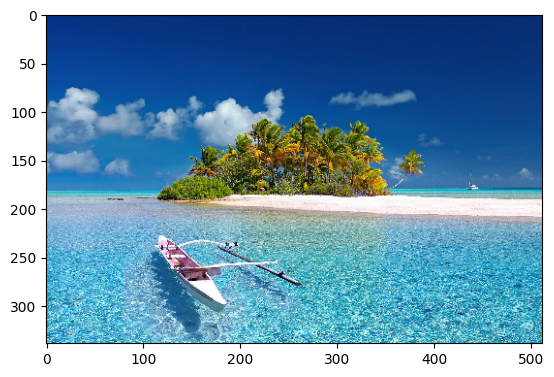

In [43]:
# content image의 크기 조절
# - 임의의 사이즈로 리사이즈를 하면, 종회비가 깨져 원본이 왜곡됨
#      원하는 크기로 할 떄의 종횡비를 계산해서 하려고 코드화 작업
max_dim = 512
long_dim  = max(content_image.shape[:-1] ) # 1460 by 2200
scale = max_dim / long_dim                  # 1460 / 512, 2200/512
new_height = int( content_image.shape[0] * scale )
new_width = int( content_image.shape[1] * scale )

content_image = cv2.resize( content_image, dsize= (new_width,  new_height))
content_image = content_image / 255.0 # 픽셀값 정규화

plt.imshow(content_image)
# ---> 이미지의 가로의 크기를 512로 하고 세로를 원본 비율에 맞춰서 하고 싶은 것

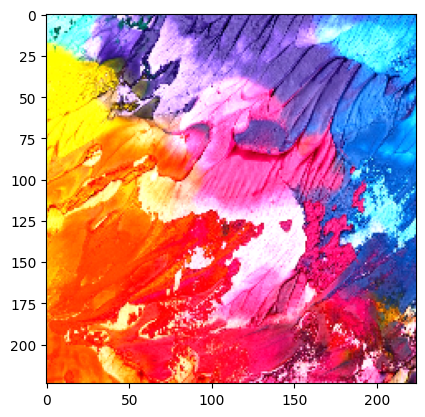

In [44]:
# Style 관련 이미지
plt.imshow(style_image)

In [58]:
# -> 위의 Style + content를 합치는 부분
# content_image도 VGG을 통과시켜야 하는데, 1장---> ( 1, 512,333, 3)
content_batch = content_image.astype("float32")

# 1장으로 batch 가능하게 3차원을 4차원으로 변경
content_batch = tf.expand_dims( content_batch, axis = 0 )


In [59]:
# 앞 style에서는 5개의 레이어에서 추출
# content는 맨 마지막쪽에서 추출 1개만 하면 됨
# 논문에서는 5번째의 2째에서 추출하도록 함
content_layers = ["block5_conv2"] # 논문상 1번만 추출해서 계산을 하므로
vgg.trainable= False

In [60]:
## 출력에 대해서 처리
outputs = [ vgg.get_layer(name).output for name in content_layers ]
model_content = tf.keras.Model([vgg.input],outputs )
content_output = model_content( preprocess_input( content_batch * 255.0))
# ---> VGG가 8비트의 픽셀값(0~255)을 바탕으로 전처리를 해서

In [61]:
content_output.shape

TensorShape([1, 21, 32, 512])

In [62]:
# content에 대한 output을 적용
def get_content_output( image ):
    image_batch = tf.expand_dims(image, axis=0)
    # model -> model_content로 수정해야 함; style 쪽 model을 사용함;
    # output = model(preprocess_input(image_batch * 255.0))
    output = model_content(preprocess_input(image_batch * 255.0))
    return output

In [63]:
# Style쪽의 output 관련 부분 : grammaix + 여러 층에서 다 뽑아 내야 해서
# def get_outputs(image):
#     image_batch = tf.expand_dims(image, axis=0)  # (224,224,3)-->(1,224,224,3)
#     output = model(preprocess_input(image_batch * 255.0))
#     outputs = [gram_matrix(out) for out in output]
#     return outputs

In [64]:
# content loss
def get_content_loss(image, content_output):
    return tf.reduce_sum(tf.reduce_mean(image-content_output)**2)

In [65]:
# style loss
# def get_loss( outputs, style_outputs):
#     return tf.reduce_sum([tf.reduce_mean((o-s)**2) for o,s in zip(outputs, style_outputs)])


In [66]:
# keras의 문서에서 추가된 부분...
#   픽셀별로 차이가 좀 심하게 값의 차이가 발생할 수 있음
#   -> 차이를 줄여주기 위해서 variance를 적용해서 처리를 하려고 함
#   -> content쪽은 이런 variance 처리가 좀 하면 좋겠다

def hig_pass_x_y(image):
    # 오타나서 이 부분에 수정 -1:--> :-1로
    x_var = image[:,1:,:] - image[:,:-1,:]
    y_var = image[1:,:,:] - image[:-1,:,:]
    return x_var, y_var

def total_variation_loss( image):
    x_delta, y_delta = hig_pass_x_y(image)
    return tf.reduce_mean(x_delta**2 ) + tf.reduce_mean(y_delta**2 )

In [67]:
# Train쪽을 수정
# + optimizer
opt = tf.optimizers.Adam(learning_rate=0.2,
                         beta_1=0.99,
                         epsilon=1e-1)

In [68]:
# 학습하는 과정에서,,,Total Loss에서
#     비율을 지정해야 하는 것이 필요함!!!
#     alpha + beta (style/ content이 강조 비율)
# 픽셀에 대한 분산을 조정하는 파라미터도 추가( 논문가 별개 )
style_weight = 1e-2  # beta
content_weight =1e4  # alpha

# + 분산을 조정을 해서 어느 정도 반영할지( 코드상 추가된 파라미터..)
total_variation_weight = 1e9 ## 논문이 아니라 코드상 실험으로 추가된 파라미터

In [69]:
@tf.function()
def train_step( image):
    with tf.GradientTape() as tape : # tape 암묵적으로 변수명 pandas -> pd

        # style쪽 loss계산을 위한 output들
        outputs = get_outputs( image ) # GM의 값들을 뽑아낼 것

        # +++ content쪽 loss 계산을 위한 output : 수정!!!
        outputs2 = get_content_output(image)

        ##################################
        # loss를 계산을 하려고 함....
        loss = style_weight * get_loss(outputs, style_outputs ) # style_loss
        loss += content_weight * get_content_loss( outputs2, content_output) # content_loss
        #---> 논문은 Total Loss
        # ++ 실험상 픽셀의 차이를 줄여주기 위해서.보상을 함. variance를 중심으로
        loss += total_variation_weight * total_variation_loss( image )
        # ======> Loss는 그냥 내가 조절하고 싶은 대상들을 선정해서, 계량화해서
        #         계산의 대상으로 선택하면 됨!
        # 네트워크한데,이런 것들을 고려해서 학습. 고려 대상!!
        # 고려대상 : loss추가 네트워크 구조에 추가 등등...
        # loss를 할 때 계산의 용이성도 고려하고, 시간 효율성, 기타 등등 고려해야 함.
        # Diffusion ---> VAE ---> stableDiffusion loss 타켓을 좀 수정해서,간단하게 좀 하자!!

    grad = tape.gradient( loss, image )
    opt.apply_gradients( [ (grad, image )]) # 갱신 : 메서드상 ()--> []
    image.assign( clip_0_1(image))

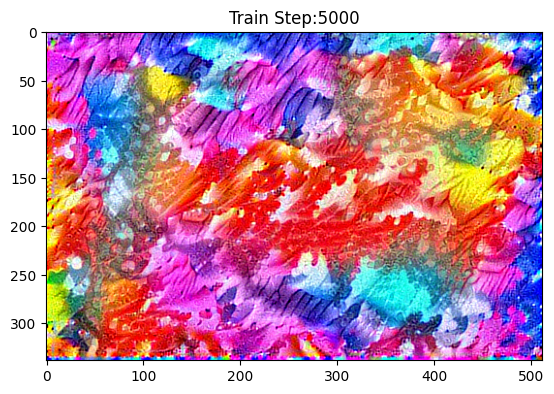

In [70]:
# Style에 대한 전이에 대한 부분의 반복
import IPython.display as display
import imageio
from PIL import Image

# ---> 이것을 조금 변경해보겠음..
#      시간 관계상 content에서 시작을 시작을 시키겠습니다
#image = tf.Variable( target_image)
# ---> 시간 관계상 완전 Random에서 시작을 할 수도 있는데
#       여기서는 기존의 content에서 기반으로 시작을 하도록 하는 것
image = tf.Variable(content_image.astype("float32") )

epochs = 50
step_per_epoch= 100

step = 0
for n in range(epochs):
    for m in range(step_per_epoch):
        step += 1
        train_step(image) # 학습을 시키는 과정.
    ### 옵션들
    if n % 5 ==0 or n == (epochs-1):
        # 실제 어떻게 학습했나 확인
        tf.keras.utils.save_img('style_epoch_{0}.png'.format(n),image.read_value().numpy())
    # 밑에 출력
    display.clear_output(wait=True) # 그냥 다 볼려면, False  하거나 주석
    plt.imshow( image.read_value() )
    plt.title("Train Step:{}".format(step))
    plt.show()
